# Glaucoma Detection Model using Deep Learning

A deep convolutional neural network image classifier for accurately detecting glaucoma from OCT scans of the human eye. This  model is built with TensorFlow, a Python library. 

Data source: 
1. https://pmc.ncbi.nlm.nih.gov/articles/PMC7062936/
    Credit: Hina Raja et al.
2. https://www.kaggle.com/datasets/paultimothymooney/kermany2018
    Credit: Paul Mooney

Author: Jack Doughty

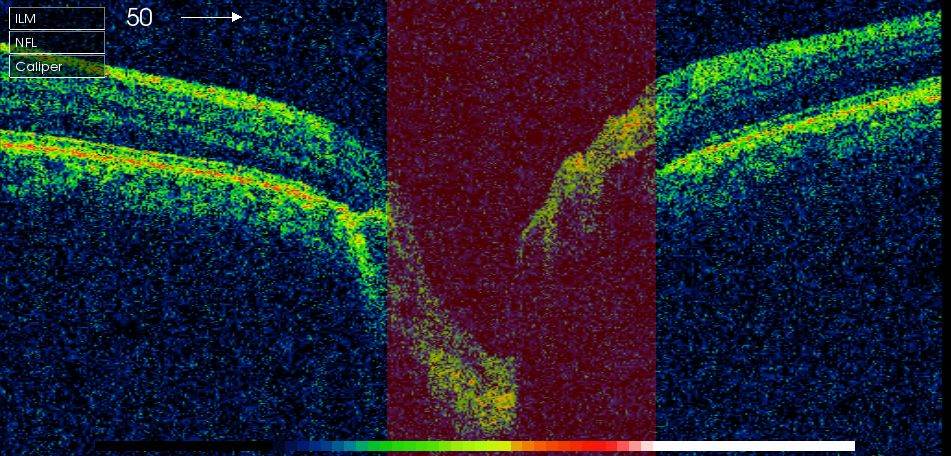

## Abstract
This study presents a deep learning-based approach for automated glaucoma detection using VGG16, a convolutional neural network (CNN) pre-trained on ImageNet. The model was trained on 650 retinal OCT images, with data augmentation techniques applied to enhance generalization. The dataset was split into 70% training, 15% validation, and 15% test sets, ensuring balanced representation across classes.

After 23 epochs, the model achieved a test accuracy of 84.46%, with a macro-average F1-score of 0.84. The classification report indicates strong precision (0.87) and recall (0.85) across both glaucoma-positive and negative classes. The confusion matrix highlights a sensitivity of 97% for Class 0 (non-glaucoma) and 72% for Class 1 (glaucoma), indicating robust detection capabilities but room for improvement in recall for glaucoma cases.

This research demonstrates the feasibility of transfer learning and data augmentation for improving deep learning-based glaucoma screening. Future work will explore alternative architectures, hyperparameter tuning, and larger datasets to further enhance performance and clinical applicability.

### Introduction
Glaucoma is a group of eye conditions that damage the optic nerve, and consequently affecting a patient's vision. This damage is often caused by abnormally high pressure in the eye. Glaucoma is one of the leading causes of blindness for people over the age of 60. Thinning of the Retinal Nerve Fiber Layer (RNFL) is one of the most significant signs of glaucoma. The RNFL 
contains the nerve fibers that originate in the retina and come together to form the optic nerve (the bright spheres seen in the images below). Glaucoma leads to
a loss of these nerve fibers, which appears as thinning in the OCT images.

### Problem Statement
Glaucoma primarily affects vision gradually and often goes unnoticed until it's at an advanced stage. Early detection and treatment can help stop vision loss. However, early detection can be difficult to decipher from an OCT scan with the naked eye as it is very subtle when compared to a healthy eye. 

Methodology
I propose creating a deep convolutional neural network image classifier to resolve the issue of detecting glaucoma in its early stages from an OCT scan. The model will be trained with a deep learning algorithm using 520 OCT scans of eyes affected by glaucoma and also healthy eyes. This will be achieved using Python libraries including TensorFlow and Keras.

#### Import Libraries

In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import shutil
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
#Import Necessary tensorflow packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tf.keras.optimizers.legacy.Adam import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

#### Import Datasets:

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/kermany2018")

In [13]:
for dirname, _, filenames in os.walk('/Users/jackdoughty/Deep Image Classifier/DATA'):
    for filename in filenames:
        os.path.join(dirname, filename)

all_files = os.listdir('/Users/jackdoughty/Deep Image Classifier/DATA/Glaucoma Images/ORIGA/Images')

jpg_files = [file for file in all_files if file.lower().endswith(".jpg")]
# Count the number of images in ORIGA set
print("Number of images:", len(jpg_files))

Number of images: 650


In [20]:
#Import glaucoma csv and investigate the data
data = pd.read_csv('/Users/jackdoughty/Deep Image Classifier/DATA/Glaucoma Images/glaucoma.csv')

#### Check datasets and prepare for training

In [23]:
print(data.info())  # Overview of dataset (column types, non-null counts)
print(data.describe())  # Summary statistics for numerical columns
print(data.columns)  # List of column names
print(data.shape)  # (Rows, Columns)
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Filename  650 non-null    object 
 1   ExpCDR    650 non-null    float64
 2   Eye       650 non-null    object 
 3   Set       650 non-null    object 
 4   Glaucoma  650 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 25.5+ KB
None
           ExpCDR    Glaucoma
count  650.000000  650.000000
mean     0.576308    0.258462
std      0.116395    0.438126
min      0.161000    0.000000
25%      0.496675    0.000000
50%      0.567650    0.000000
75%      0.648475    1.000000
max      0.962900    1.000000
Index(['Filename', 'ExpCDR', 'Eye', 'Set', 'Glaucoma'], dtype='object')
(650, 5)


,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0


#### Check for NA values and Unique values

Filename    0
ExpCDR      0
Eye         0
Set         0
Glaucoma    0
dtype: int64


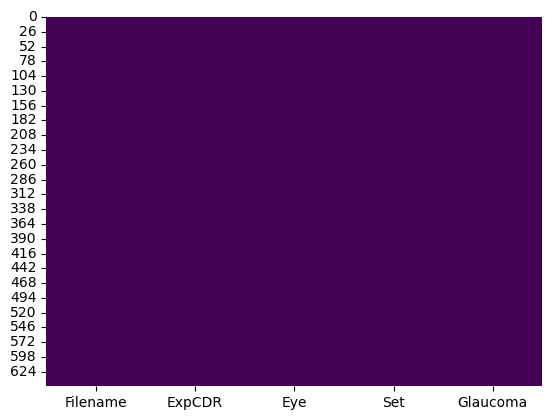

Filename: 650 unique values
ExpCDR: 583 unique values
Eye: 2 unique values
Set: 2 unique values
Glaucoma: 2 unique values


In [15]:
print(data.isna().sum())  # Count of missing values per column
sns.heatmap(data.isna(), cmap="viridis", cbar=False)  # Heatmap of missing values
plt.show()

# Unique values per column
for col in data.columns:
    print(f"{col}: {data[col].nunique()} unique values")

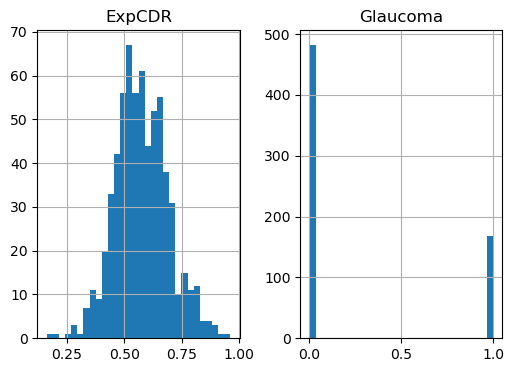

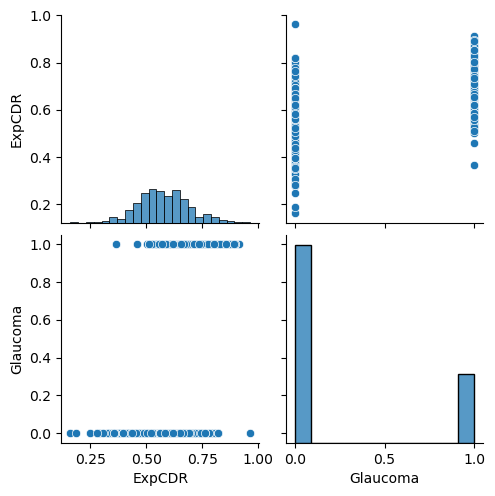

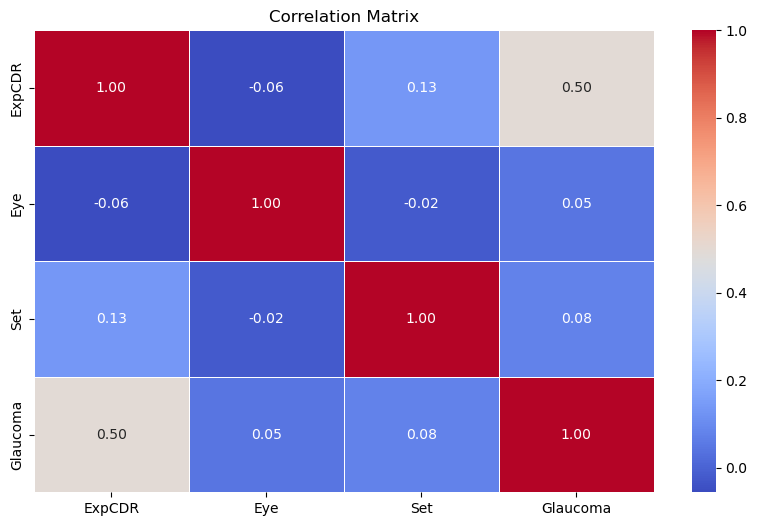

In [32]:
# Histogram for numerical data
data.hist(figsize=(6, 4), bins=30)
plt.show()

# Pairplot to see relationships (useful for small datasets)
sns.pairplot(data)
plt.show()

#Prepare data for correlation matrix heatmap
df = data.drop('Filename', axis=1)
encoder = LabelEncoder()
df['Eye'] = encoder.fit_transform(df['Eye'])
df['Set'] = encoder.fit_transform(df['Set'])

# Correlation matrix heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

There is an imbalance in labels, this will be corrected. There are no notable correlations between encoded variables and glaucoma. The models will depend on the images in order to accurately detect Glaucoma. 

In [36]:
# Paths
base_dir = "/Users/jackdoughty/Deep Image Classifier/DATA/Glaucoma Images/ORIGA"
csv_file_path = "/Users/jackdoughty/Deep Image Classifier/DATA/Glaucoma Images/glaucoma.csv"
image_dir = os.path.join(base_dir, "Images")
output_dir = "/Users/jackdoughty/Deep Image Classifier/DATA/Glaucoma Images/augmented_data"

# Load the CSV file
data = pd.read_csv(csv_file_path)

# Create output directories for 'yes' and 'no'
yes_folder = os.path.join(output_dir, "positive")
no_folder = os.path.join(output_dir, "negative")

# Subfolders for images and CSVs
yes_images_folder = os.path.join(yes_folder, "images")
yes_csv_folder = os.path.join(yes_folder, "csv")
no_images_folder = os.path.join(no_folder, "images")
no_csv_folder = os.path.join(no_folder, "csv")

# Create all necessary folders
os.makedirs(yes_images_folder, exist_ok=True)
os.makedirs(yes_csv_folder, exist_ok=True)
os.makedirs(no_images_folder, exist_ok=True)
os.makedirs(no_csv_folder, exist_ok=True)

# Separate data based on 'Glaucoma' values
yes_data = data[data["Glaucoma"] == 1]
no_data = data[data["Glaucoma"] == 0]

# Function to organize images and save CSVs
def organize_data(subset_data, images_folder, csv_folder):
    for _, row in subset_data.iterrows():
        filename = row["Filename"]
        src_path = os.path.join(image_dir, filename)
        dest_path = os.path.join(images_folder, filename)
        
        # Copy image
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
    
    # Save corresponding CSV in the 'csv' subfolder
    csv_path = os.path.join(csv_folder, "data.csv")
    subset_data.to_csv(csv_path, index=False)

# Organize data for 'yes' and 'no' classes
organize_data(yes_data, yes_images_folder, yes_csv_folder)
organize_data(no_data, no_images_folder, no_csv_folder)

print(f"Data organized into 'postive' and 'negative' folders with separate subfolders for images and CSVs")


Data organized into 'postive' and 'negative' folders with separate subfolders for images and CSVs


In [37]:
no_path = "/Users/jackdoughty/Deep Image Classifier/DATA/Glaucoma Images/augmented_data/negative/images"
yes_path = "/Users/jackdoughty/Deep Image Classifier/DATA/Glaucoma Images/augmented_data/positive/images"
# List all files in the directory
nofiles = os.listdir(no_path)
yesfiles = os.listdir(yes_path)

no_files = [file for file in nofiles if file.lower().endswith(".jpg")]
yes_files = [file for file in yesfiles if file.lower().endswith(".jpg")]
# Count the number of images
print("# of images in negative directory:", len(no_files))
print("# of images in positive directory:", len(yes_files))


# of images in negative directory: 482
# of images in positive directory: 168


Augment each positive image with 2 additional images. This is to balance out the labels.

In [ ]:
# Paths
yes_images_folder = yes_path
output_dir = "/Users/jackdoughty/Deep Image Classifier/DATA/Glaucoma Images/augmented_data/augmented"
aug_images_folder = os.path.join(output_dir, "images")
aug_csv_folder = os.path.join(output_dir, "csv")
yes_csv_path = "/Users/jackdoughty/Deep Image Classifier/DATA/Glaucoma Images/augmented_data/positive/csv/data.csv"

# Load the CSV file
yes_data = pd.read_csv(yes_csv_path)

# Create output directories for augmented data
os.makedirs(aug_images_folder, exist_ok=True)
os.makedirs(aug_csv_folder, exist_ok=True)

# Define augmentation transformations
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)
# List to store new rows for CSV
augmented_rows = []

# Augment Images and Create New Data
for _, row in yes_data.iterrows():
    filename = row["Filename"]
    src_path = os.path.join(yes_images_folder, filename)

    if os.path.exists(src_path):
        # Load the original image
        img = Image.open(src_path)
        img_array = np.expand_dims(np.array(img), axis=0)

        # Save the original image to the new folder
        new_filename = filename
        new_path = os.path.join(aug_images_folder, new_filename)
        img.save(new_path)

        # Add the original image row to augmented_rows
        new_row = row.copy()
        new_row["Filename"] = new_filename
        augmented_rows.append(new_row)

        # Generate 2 augmented images
        i = 1
        for batch in datagen.flow(img_array, batch_size=1):
                augmented_filename = f"{os.path.splitext(filename)[0]}_{i}.jpg"
                augmented_image_path = os.path.join(aug_images_folder, augmented_filename)

                # Save the augmented image
                augmented_img = Image.fromarray(batch[0].astype("uint8"))
                augmented_img.save(augmented_image_path)

                # Add new augmented image row to augmented_rows
                new_augmented_row = row.copy()
                new_augmented_row["Filename"] = augmented_filename
                augmented_rows.append(new_augmented_row)

                i += 1
                if i > 2:  # We need exactly 2 augmented images (total of 3 images: original + 2 augmented)
                    break

# Save updated CSV with 3 images (original + 2 augmented) for each entry
augmented_data = pd.DataFrame(augmented_rows)
augmented_data.to_csv(os.path.join(aug_csv_folder, "data.csv"), index=False)

print(f"Augmented images saved to '{aug_images_folder}' and CSV updated at '{aug_csv_folder}/data.csv'.")

#### Check if imbalance issue has been fixed

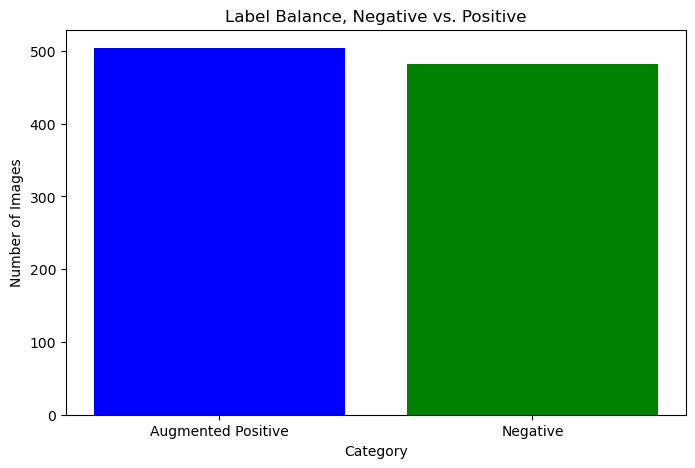

In [41]:
# Paths to the image folders
aug_yes_images_folder = "/Users/jackdoughty/Deep Image Classifier/DATA/Glaucoma Images/augmented_data/augmented/images"
no_images_folder = "/Users/jackdoughty/Deep Image Classifier/DATA/Glaucoma Images/augmented_data/negative/images"

num_aug_yes_images = len([img for img in os.listdir(aug_yes_images_folder) if img.endswith(".jpg")])
num_no_images = len([img for img in os.listdir(no_images_folder) if img.endswith(".jpg")])

# Data for the bar chart
categories = ['Augmented Positive', 'Negative']
counts = [num_aug_yes_images, num_no_images]

plt.figure(figsize=(8, 5))
plt.bar(categories, counts, color=['blue', 'green'])
plt.title('Label Balance, Negative vs. Positive')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()

In [43]:
print(f"Postive: {counts[0]} Negative: {counts[1]}")

Postive: 504 Negative: 482


#### Data set is adequately balanced and cleaned. Time to begin training!

In [47]:
# Function to preprocess images and create data lists
def preprocess_and_load_data(data_subset, folder_paths):
    images = []
    labels = []

    for _, row in data_subset.iterrows():
        filename = row["Filename"]
        label = row["label"]
        # Determine the folder based on the label
        image_folder = folder_paths['yes'] if label == 1 else folder_paths['no']
        image_path = os.path.join(image_folder, filename)

        if os.path.exists(image_path):
            # Load the image and resize to (224, 224) for ResNet50
            img = load_img(image_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_preprocessed = preprocess_input(img_array)  # Preprocess for ResNet50
            
            images.append(img_preprocessed)
            labels.append(label)

    return np.array(images), np.array(labels)


#### Split data into training, validation, and test sets

In [48]:
# Paths for aug_positive and negative
aug_yes_csv_path = "/Users/jackdoughty/Deep Image Classifier/DATA/Glaucoma Images/augmented_data/augmented/csv/data.csv"
aug_yes_images_folder = "/Users/jackdoughty/Deep Image Classifier/DATA/Glaucoma Images/augmented_data/augmented/images"

no_csv_path = "/Users/jackdoughty/Deep Image Classifier/DATA/Glaucoma Images/augmented_data/negative/csv/data.csv"
no_images_folder = "/Users/jackdoughty/Deep Image Classifier/DATA/Glaucoma Images/augmented_data/negative/images"

# Load CSVs
data_yes = pd.read_csv(aug_yes_csv_path)
data_yes['label'] = 1  # Assign label 1 for "positive"

data_no = pd.read_csv(no_csv_path)
data_no['label'] = 0  # Assign label 0 for "negative"

# Combine both classes and shuffle
data = pd.concat([data_yes, data_no], ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split data into train, validation, and test sets (70:15:15) while maintaining label balance
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['label'], random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42)

In [49]:
# Define image folder paths for both labels
folder_paths = {
    "yes": aug_yes_images_folder,
    "no": no_images_folder
}

# Preprocess and load data for train, validation, and test sets
train_images, train_labels = preprocess_and_load_data(train_data, folder_paths)
valid_images, valid_labels = preprocess_and_load_data(valid_data, folder_paths)
test_images, test_labels = preprocess_and_load_data(test_data, folder_paths)

# One-hot encode the labels
num_classes = 2  # Glaucoma has two classes: 0 and 1
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

# Output the shapes of the data
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {valid_images.shape}")
print(f"Validation labels shape: {valid_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Print class distribution in each split
print("Class distribution in Train:", np.sum(train_labels, axis=0))
print("Class distribution in Validation:", np.sum(valid_labels, axis=0))
print("Class distribution in Test:", np.sum(test_labels, axis=0))

Train images shape: (690, 224, 224, 3)
Train labels shape: (690, 2)
Validation images shape: (148, 224, 224, 3)
Validation labels shape: (148, 2)
Test images shape: (148, 224, 224, 3)
Test labels shape: (148, 2)
Class distribution in Train: [337. 353.]
Class distribution in Validation: [72. 76.]
Class distribution in Test: [73. 75.]


Create VGG16 model function that returns a VGG116 model ready to be trained. VGG16 is a deep convolutional neural network (CNN) architecture developed by the Visual Geometry Group (VGG) at the University of Oxford. It was introduced in the ILSVRC-2014 (ImageNet Large Scale Visual Recognition Challenge) and is widely used for image classification, object detection, and transfer learning

In [55]:
# Define data augmentation for the training set
data_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define VGG16 model
def create_vgg16_model(input_shape, num_classes):
    # Load the VGG16 base model with pre-trained weights
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model layers for transfer learning
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom classification layers
    x = base_model.output
    x = Flatten()(x)  # Flatten the output of the base model
    x = Dense(256, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.5)(x)  # Dropout for regularization
    predictions = Dense(num_classes, activation='softmax')(x)  # Final classification layer
    
    # Compile the model
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

This function adjusts the learning rate as epochs progress. Every 5 epochs, the learing rate decreases by 10%. If at any point the validation loss function does not improve after 7 epochs, training stops (early stopping). 

In [56]:
def lr_schedule(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr *= 0.9
    return float(lr)  # Ensure the return value is a float

learning_rate_scheduler = LearningRateScheduler(lr_schedule)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

The model input and shape is set and the model is trained on 50 epochs. Early stopping is active in case validation accuracy does not improve. Every 5 epochs, the learning rate reduces by 10%.

In [60]:
# Model configuration
input_shape = (224, 224, 3)
num_classes = 2  # Yes and No classes
model = create_vgg16_model(input_shape, num_classes)

# Training the model
history = model.fit(
    data_gen.flow(train_images, train_labels, batch_size=32),
    epochs=50,
    validation_data=(valid_images, valid_labels),
    callbacks=[early_stopping, learning_rate_scheduler]
)

Epoch 1/50
22/22 [==============================] - 57s 3s/step - loss: 4.9510 - accuracy: 0.6362 - val_loss: 5.5588 - val_accuracy: 0.6149 - lr: 1.0000e-04
Epoch 2/50
22/22 [==============================] - 57s 3s/step - loss: 2.7088 - accuracy: 0.7188 - val_loss: 1.6606 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 3/50
22/22 [==============================] - 57s 3s/step - loss: 1.3991 - accuracy: 0.7362 - val_loss: 1.4222 - val_accuracy: 0.7027 - lr: 1.0000e-04
Epoch 4/50
22/22 [==============================] - 57s 3s/step - loss: 0.9143 - accuracy: 0.7348 - val_loss: 0.8561 - val_accuracy: 0.7365 - lr: 1.0000e-04
Epoch 5/50
22/22 [==============================] - 57s 3s/step - loss: 0.7784 - accuracy: 0.7304 - val_loss: 0.6577 - val_accuracy: 0.7365 - lr: 1.0000e-04
Epoch 6/50
22/22 [==============================] - 57s 3s/step - loss: 0.5241 - accuracy: 0.7783 - val_loss: 0.7290 - val_accuracy: 0.7162 - lr: 9.0000e-05
Epoch 7/50
22/22 [==============================] - 57s 3s

After 23 epochs the functions validation loss converged. The model restores the best weights before stopping, so the most optimized parameters are returned.

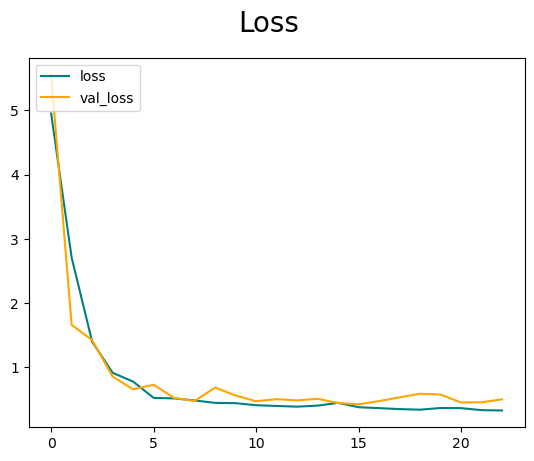

In [62]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#### Evaluate Model Performance

Test images shape: (148, 224, 224, 3)
Test labels shape: (148, 2)
Sample test labels (one-hot): [[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
5/5 [==============================] - 10s 2s/step
VGG16 Test Accuracy: 84.46%

Classification Report (VGG16):
              precision    recall  f1-score   support

     Class 0       0.77      0.97      0.86        73
     Class 1       0.96      0.72      0.82        75

    accuracy                           0.84       148
   macro avg       0.87      0.85      0.84       148
weighted avg       0.87      0.84      0.84       148


Confusion Matrix (VGG16):


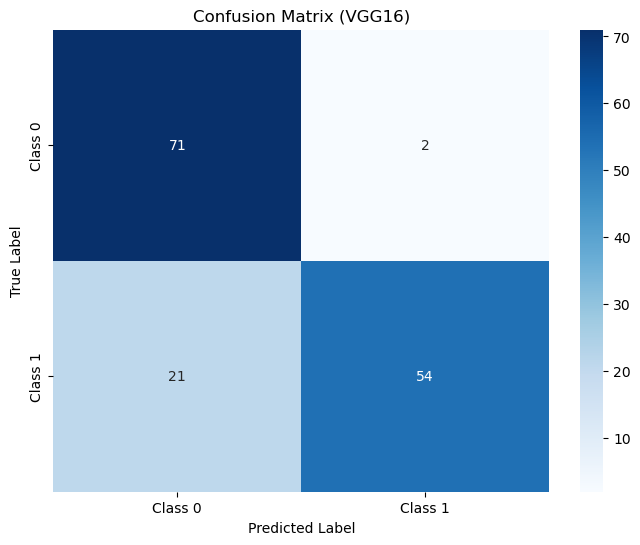

In [66]:
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Sample test labels (one-hot): {test_labels[:10]}")

# Convert one-hot encoded test labels to integer format
test_labels_int = test_labels if len(test_labels.shape) == 1 else np.argmax(test_labels, axis=1)

# Predict using the VGG16 model
vgg16_predictions = model.predict(test_images)
vgg16_predicted_classes = np.argmax(vgg16_predictions, axis=1)  # Convert predictions to class indices

# Calculate accuracy
vgg16_test_accuracy = accuracy_score(test_labels_int, vgg16_predicted_classes)
print(f"VGG16 Test Accuracy: {vgg16_test_accuracy * 100:.2f}%")

# Generate classification report
print("\nClassification Report (VGG16):")
target_names = [f"Class {cls}" for cls in np.unique(test_labels_int)]  # Dynamically create target names
print(classification_report(test_labels_int, vgg16_predicted_classes, target_names=target_names))

# Generate confusion matrix
print("\nConfusion Matrix (VGG16):")
vgg16_conf_matrix = confusion_matrix(test_labels_int, vgg16_predicted_classes)

# Optional: Visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(vgg16_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix (VGG16)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


The model performed exceptionally well on the test set, scoring 84.46% accuracy 

#### Finally, Save model for future deployment

In [67]:
# Save the VGG16 model and weights
vgg16_weights_path = './vgg16_model_weights.weights.h5'
vgg16_model_path = './vgg16_model.h5'

model.save_weights(vgg16_weights_path)
model.save(vgg16_model_path)

print("VGG16 model and weights saved successfully")

VGG16 model and weights saved successfully


/Users/jackdoughty/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
